This is a continuation of the previous two Mie Scattering notebooks, created because the other two were starting to get messy and long, so this will keep things more organized and require less scrolling down.

In [2]:
# All of the imports and basic functions from the Mie Scattering notebook
import scipy.special as fn
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from time import sleep
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

#Define functions for S_n(z), C_n(z), Φ_n(z), and their derivatives (derivatives denoted with a "d")

def S(n,z):
    return np.sqrt(np.pi/2*z)*fn.jv(n+1/2,z)  # fn.jv(k,z) is the Bessel function J_k(z)

def dS(n,z):
    v = n+1/2
    s = np.sqrt(np.pi/2*z)*fn.jvp(v,z)    # fn.jvp(k,z) is the derivative of the Bessel function (wrt z)
    t = np.sqrt(np.pi/(2*z))/2*fn.jv(v,z)
    return s+t

def C(n,z):
    v = n+1/2
    return (-1)**n*np.sqrt(np.pi/2*z)*fn.jv(-v,z)

def dC(n,z):
    v = n+1/2
    s = np.sqrt(np.pi/2*z)*fn.jvp(-v,z)
    t = 0.5*np.sqrt(np.pi/(2*z))*fn.jv(-v,z)
    return (-1)**n*(s+t)

def phi(n,z):
    return S(n,z)+1j*C(n,z)

def dphi(n,z):
    return dS(n,z)+1j*dC(n,z)

#Now I define functions for a_n and b_n and a function for the nth term in the infinite series in the expression
# for the cross section.
#l is λ₀, r & m represent the same things as above.

def a_n(n,l,r,m):
    alpha = 2*np.pi*r/l
    beta = m*alpha
    top = S(n,alpha)*dS(n,beta)-m*S(n,beta)*dS(n,alpha)
    bot = dS(n,beta)*phi(n,alpha)-m*S(n,beta)*dphi(n,alpha)
    return (-1)**(n+1/2)*top/bot

def b_n(n,l,r,m):
    alpha = 2*np.pi*r/l
    beta = m*alpha
    top = m*S(n,alpha)*dS(n,beta)-S(n,beta)*dS(n,alpha)
    bot = m*dS(n,beta)*phi(n,alpha)-S(n,beta)*dphi(n,alpha)
    return (-1)**(n+3/2)*top/bot

def term(n,l,r,m):
    return (2*n+1)*(abs(a_n(n,l,r,m))**2+abs(b_n(n,l,r,m))**2)

#This function calculates the cross section. l is λ₀, r & m represent the same things as above.
def cs(l,r,m):
    total = 0  #I use a while loop to add up the infinite sum
    nterm = 1
    n=1
    while np.all(abs(nterm) >= 1e-35): #By the time the terms get this small, the sum has already converged to the answer.
        nterm = term(n,l,r,m)
        n+=1
        total+=nterm
    return l**2/2/np.pi*total

#function for transmission. lam = λ₀, Ka & Ks are K_2^a & K_2^s, other variable names are the same as above
def trans(lam,K1,Ka,l,Ns,r,m):
    Ks = cs(lam,r,m)*Ns
    T = np.exp(-(K1+Ka+Ks)*l)
    return T

In [17]:
# Relevant functions from Mie Scattering 2

# temperature dependence of refractive index, explained in more detail Mie Scattering 2
def refr(temp,a,b,c):
    return (1+b/(1+a*temp+c*temp**2)**3)**0.5

# function for refractive index, where X includes both temperature and wavelength, and the rest ae free parameters
# It adds together a wavelength dependent part and a temperature dependent part
def ultref(X,a,b,c,A,B):
    temp,wavl=X
    tempdep = refr(temp,a,b,c)
    wavdep = A+B/wavl**2
    return tempdep+wavdep

# best fit parameters for ultref for Kr and Ar films
parms = [-2.02823499e-03, -4.20714203e-02, -2.61489404e-06,  3.92796537e-01,  2.72062705e+05]
paras = [-1.29167098e-05,  6.30773716e-01,  4.92941185e-06,  1.01255347e-02,  1.51596006e+05]

# bubble outputs a function for Mie scattering transmission based on the bubble model for a film of a given
# substance and temperature.
Kr = 'Kr'
Ar = 'Ar'
def bubble(film,temp):
    # Based on the type of film, choose the parameters for ultref
    if film == Kr:
        putin = parms
    if film == Ar:
        putin = paras 
    # bubble is a second order function that will output a function where the film type and temperature are fixed
    def model(lam,r,Ns):
        vals = [temp, lam]
        n = ultref(vals,*putin)
        return trans(lam,0,0,100e-6,Ns,r,1/n)
    return model

# Bubble outputs a functions like the one returned by bubble, but with a constant factor as a free parameter
def Bubble(film,temp):
    def model(lam,r,Ns,const):
        return const*bubble(film,temp)(lam,r,Ns)
    return model

#Calculates the bubble model fit for a film given wavelength and transmission data, outputs parameters, and plots it
def Modelfit(film,temp,wavl,tr,guesses,size=None,const=False,scat=False):
    # const represents whether or not a constant multiple is included as a free parameter
    if const:
        model = Bubble(film,temp)
    else:
        model = bubble(film,temp)
    # Calculates the best fit parameters, covariance matrix, and output values of the best fit model
    popt, pcov = curve_fit(model,wavl,tr,guesses)
    trfit = model(wavl,*popt)
    plt.figure(figsize=size)
    # Creates a line or scatter plot of the best fit model and the actual data
    if not scat:
        plt.plot(wavl*1e9,trfit,label='fit')
        plt.plot(wavl*1e9,tr,label='data')
    if scat:
        plt.scatter(wavl*1e9,trfit,label='fit',s=1)
        plt.scatter(wavl*1e9,tr,label='data',s=1)
    plt.legend()
    plt.title("{} film, {}K".format(film, temp))
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Transmission")
    # calculates root mean squared error (unbiased estimate)
    sq = sum((trfit-tr)**2)
    umse = sq/(len(wavl)-len(guesses))
    rumse = umse**0.5
    return popt, pcov, rumse

# function for loading in wavlength and transmission data  
# the path variable will have to be changed when using it on any device other than my laptop
def loadin(film,temp,date,times,app="",ins="_",style=0):
    path = "C:\\Users\\jrnoo\\OneDrive\\Documents\\Mie Model\\{} {}{}\\data\\".format(film,temp,app)#path to files
    st = "_FLMS138901_"  # this string shows up in the file names
    # The files don't follow a consistent naming convention - there are actually three different conventions,
    #which these styles represent.
    # The dark, film, and nofilm files are loaded in from each (transmission is calculated from the values in these
    #files).
    if style==0:
        dname = "{}_{}_{}K_dark{}{}.txt".format(date,film,temp,st,times[0])
        fname = "{}_{}_{}K_film{}{}.txt".format(date,film,temp,st,times[1])
        nname = "{}_{}_{}K_no{}film{}{}.txt".format(date,film,temp,ins,st,times[2])
    if style==1:
        dname = "{}_{}_Darkcount_{}K{}{}.txt".format(date,film,temp,st,times[0])
        fname = "{}_{}_With_Film_{}K{}{}.txt".format(date,film,temp,st,times[1])
        nname = "{}_{}_No_Film_{}K{}{}.txt".format(date,film,temp,st,times[2])
    if style==2:
        dname = "{}{}_dark{}{}.txt".format(date,ins,st,times[0])
        fname = "{}{}_film{}{}.txt".format(date,ins,st,times[1])
        nname = "{}{}_nofilm{}{}.txt".format(date,ins,st,times[2])
    arr1 = np.loadtxt(path+"dark\\"+dname,skiprows=14)
    arr2 = np.loadtxt(path+"film\\"+fname,skiprows=14)
    arr3 = np.loadtxt(path+"nofilm\\"+nname,skiprows=14)
    # The first column of each file is the wavelength data (same for all three), and the second col is the data 
    #specific to that file
    wavl = arr1[:,0]*1e-9
    dark = arr1[:,1]
    film = arr2[:,1]
    nofilm = arr3[:,1]
    # transmission is calculated from the values in the second columns of the files
    tr = ((film-dark)/(nofilm-dark))
    return wavl, tr

#plots the transmission values against wavelength. 
#The values must be defined as wavl and tr before running the function in order for it to work.
def display():
    plt.plot(wavl*1e9,tr)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Transmission")

# cuts out the beginning and end of a list, used to get rid of noisy data
def redomain(lists,st="",end=""):
    new = []
    for i in lists:
        if st=="" and end=="":
            pass
        elif st=="":
            i = i[:end]
        elif end=="":
            i = i[st:]
        else:
            i = i[st:end]
        new.append(i)
    return new

In [9]:
Artimes = [["17-07-32-813","17-06-22-722","15-56-51-684"],
           ["13-19-08-236","13-18-13-163","11-39-24-612"],
           ["13-56-32-591","13-53-32-321","12-34-15-341"],
           ["14-12-33-673","13-53-56-495","12-35-11-928"],
           ["13-11-20-999","13-09-30-240","11-57-56-400"],
           ["13-47-57-541","13-46-42-088","12-37-07-018"],
           ["11-55-49-453","11-54-08-870","10-34-42-402"],
           ["16-02-53-759","16-01-18-261","14-44-46-840"],
           ["13-24-03-335","13-23-08-261","11-45-45-042"],
           ["15-00-14-000","14-58-43-415","13-45-49-884"],
           ["18-30-47-385","18-29-17-263","16-31-34-337"],
           ["17-58-51-055","17-57-15-921","16-46-04-963"],
           ["13-40-27-398","13-38-46-730","12-20-52-807"],
           ["13-25-04-521","13-23-43-975","12-13-17-637"],
           ["17-13-20-630","17-11-56-567","15-26-31-621"],
           ["17-47-23-582","17-45-27-807","16-19-51-437"],
           ["15-06-15-313","15-04-30-269","13-06-50-910"]]

Ar1 = [[22,190703],[22,190703],[24,190708],[24,190715],[25,190724],[25,190729],[26,190717],[26,190718],
          [26,190612],[28,190722],[28,190612],[30,190709],[32,190711],[33,190726],[34,190410],[34,190712],
          [36,190411]]

Arkwargs = [{},{"app":" bad"},{},{"app":"(1)"},{},{"app":"(1)"},{},{"app":"(1)"},{"app":"(2)"},{},{"app":"(1)"},{},
            {},{},{"style":1},{"app":"(1)","ins":""},{"style":1}]

Arargs=[]
for i in range(17):
    j = Ar1[i]
    j.append(Artimes[i])
    Arargs.append(tuple(j))
    
Arred = [{},{"st":24},{"st":24},{"st":24},{"st":24,"end":2020},{"st":24,"end":2020},{"st":24,"end":2000},
        {"st":24},{"st":24,"end":2000},{"st":24,"end":2000},{"st":41,"end":2000},{"st":24,"end":2005},
        {"st":24,"end":2015},{"st":24,"end":2020},{"st":24},{"st":24,"end":2020},{"st":24}]

In [15]:
def loadAr(k):
    args = Arargs[k]
    kwargs = Arkwargs[k]
    red = Arred[k]
    wavl,tr=loadin(Ar,*args,**kwargs)
    wavl,tr=redomain([wavl,tr],**red)
    return wavl,tr

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide


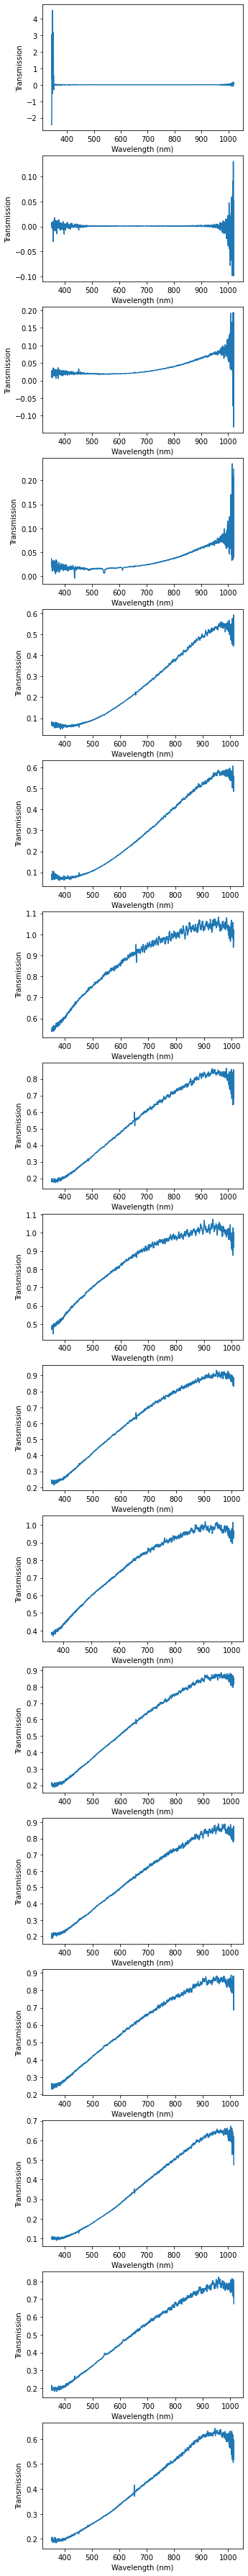

In [18]:
plt.figure(figsize=(5,65))
for i in range(17):
    plt.subplot(17,1,i+1)
    wavl,tr = loadAr(i)
    display()